In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
from pyproj import Proj
#Variables from configuration files
import config

ProcessedPath = config.SavePath
GROUPS = config.GROUPS



In [11]:
ProcessedPath

'/media/amlan/Data/Thesis Data/Processed Data/'

In [2]:
max_days = {}
for j in GROUPS:
    print(j+'\n')
    SavePath = ProcessedPath + str(j) + '/GPS_Days/'
    paths = os.listdir(SavePath)
    date,ind= [],[]
    for i in paths:
        data =  pd.read_csv(SavePath + '/'+ i ,index_col=0)
        
        print(i + ':' ,sorted(data['Individual'].unique()))
        date.append(i)
        ind.append(len(data['Individual'].unique()))
    max_item = max(ind)
    if max_item>=4:
        index_list = [date[index] for index in range(len(ind)) if ind[index] == max_item]
        max_days[j] = [index_list,max_item]
    print('Max {} individuals on day: {}'.format(max_item,index_list))
    print('\n')

NQ_2021_1

2021-08-11: ['VNQF013', 'VNQF014', 'VNQF020', 'VNQM012', 'VNQM018']
2021-08-12: ['VNQF013', 'VNQF014', 'VNQF020', 'VNQM012', 'VNQM018']
2021-08-13: ['VNQF014', 'VNQF020', 'VNQM012', 'VNQM018']
2021-08-14: ['VNQF014', 'VNQM018']
2021-08-15: ['VNQF014', 'VNQM018']
2021-08-16: ['VNQM018']
Max 5 individuals on day: ['2021-08-11', '2021-08-12']


ZU_2021_1

2021-05-15: ['VZUF051', 'VZUF054']
2021-05-16: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM056', 'VZUM059']
2021-05-17: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM056', 'VZUM059']
2021-05-18: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM056', 'VZUM059']
2021-05-19: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
2021-05-20: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
2021-05-21: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
2021-05-22: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
2021-05-23: ['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057']


In [3]:
print(max_days)


del max_days['ZU_2021_1'][0][0]

print(max_days)


{'NQ_2021_1': [['2021-08-11', '2021-08-12'], 5], 'ZU_2021_1': [['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22'], 6], 'ZU_2021_2': [['2021-07-21', '2021-07-22'], 4]}
{'NQ_2021_1': [['2021-08-11', '2021-08-12'], 5], 'ZU_2021_1': [['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22'], 6], 'ZU_2021_2': [['2021-07-21', '2021-07-22'], 4]}


In [3]:
k = 'ZU_2021_1'
j = '2021-05-18'



Duration of data 54271


In [94]:
def sync_gps_simultaneous(data,k,j):
    print('Duration of data',data.shape[0])
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    df =  data.groupby('Timestamp')
    dfnew = df.filter(lambda x: len(x['Individual'].unique())>=5)
    
    pp = Proj(proj='utm',zone=34,ellps='WGS84',south=True)

    xx, yy = pp(dfnew["lon"].values,dfnew["lat"].values)
    dfnew["X"] = xx
    dfnew["Y"] = yy 

    
    
    dfnew = dfnew.reset_index(drop=True)
    
    times = sorted(dfnew['Timestamp'].unique())
    time_start = times[0]
    time_end = times[-1]

    time_start = time_start + pd.Timedelta(seconds=30)
    time_end = time_end - pd.Timedelta(seconds=30)

    dfnew = dfnew.loc[(dfnew['Timestamp']>=time_start) & (dfnew['Timestamp']<=time_end)] 
    if j == '2021-05-18':  
        print('Seconds removed: ',len(dfnew.loc[((dfnew['X']<581950) & (dfnew['Y']>(7.02035e6)))]))
        dfnew = dfnew.loc[~((dfnew['X']<581950) & (dfnew['Y']>(7.02035e6)))] #for 3 erroneous points on '2021-05-18', remove for others
    
    else:
        pass
    dfnew=dfnew.reset_index(drop=True)
    
    print('Duration of Simultaneous data',dfnew.shape[0])
    return dfnew

In [92]:
data['Timestamp'].unique()

TypeError: 'NoneType' object is not subscriptable

Duration of data 63251
Duration of Simultaneous data 62286


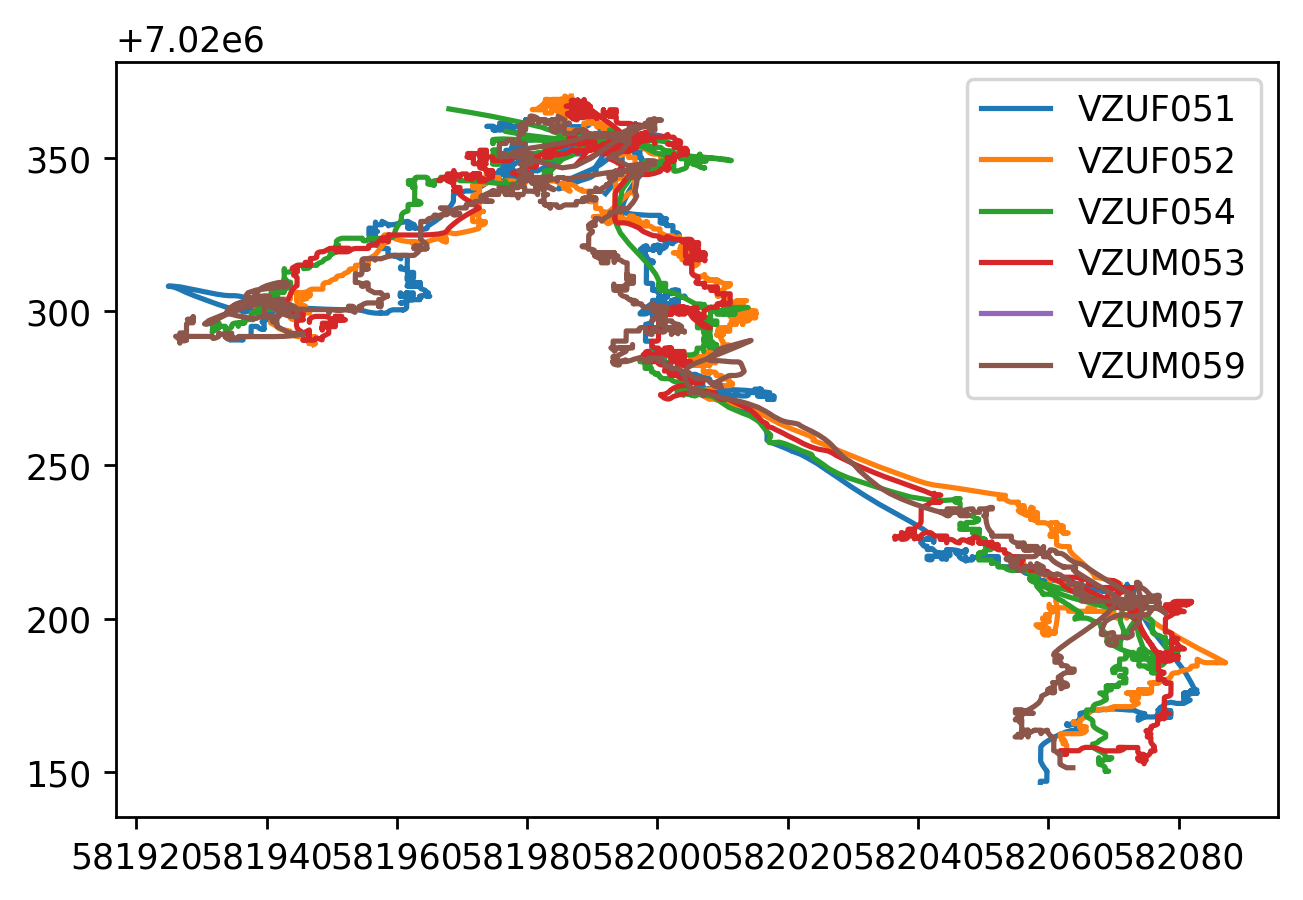

In [97]:
k = 'ZU_2021_1' #ZGroups
j = '2021-05-22' #Day
fig,ax= plt.subplots(dpi=250)
data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
data = sync_gps_simultaneous(data,k,j)

for ind in data['Individual'].unique():
        plt.plot(dfnew.loc[dfnew['Individual']==ind,'X'].rolling(center=True,window=3).mean(),dfnew.loc[dfnew['Individual']==ind,'Y'].rolling(center=True,window=3).mean(),label=ind)
plt.legend()
plt.show()


Mssing Values


In [15]:
cdict = {0:'green', 1: 'blue', 2: 'red'}
dfnew['codes'] = dfnew['Behavior'].astype('category').cat.codes
path = '/media/amlan/Data/Thesis Data/Plots/'+str(j)+'_'+str(k)
#dfnew['codes']=dfnew['codes'].apply(lambda x: cdict[x])

# Making GIFs

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches

time_start= '2021-08-11 08:20:46'
time_start =  pd.to_datetime(time_start)

time_end = '2021-08-11 08:30:46'
time_end =  pd.to_datetime(time_end)


subset = dfnew.loc[(dfnew['Timestamp']>=time_start) & (dfnew['Timestamp']<=time_end)]
subset= subset.reset_index(drop=True)


In [17]:
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True) 

In [18]:

for key,value in subset.groupby('Timestamp'):
    fig,ax = plt.subplots(dpi=200)
    #ax.set_aspect('equal', adjustable='box')
    
    width = 5
    ax.set_xlim(subset['X'].min()-width, subset['X'].max()+width)
    ax.set_ylim(subset['Y'].min()-width, subset['Y'].max()+width)
    
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.set_title('{} : {}'.format(k,key))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    
    colors = value['codes'].apply(lambda x: cdict[x])
    ax.grid()
    ax.tick_params(axis='x', rotation=45)
    ax.scatter(value['X'],value['Y'],c=colors,label=value['Individual'])
    
    red_patch = mpatches.Patch(color='red', label='Vigilance')
    green_patch = mpatches.Patch(color='green', label='Foraging')
    blue_patch = mpatches.Patch(color='blue', label='Running')

    ax.legend(handles=[red_patch,green_patch, blue_patch])
    
    plt.tight_layout()
    plt.savefig(path +'/' + str(key),dpi=250)
    plt.close(fig)
    

In [19]:
import imageio.v2 as imageio
png_dir = path
with imageio.get_writer('/media/amlan/Data/Thesis Data/Plots/'+str(k + '_' + j)+'.gif', mode='I',fps=15) as writer:
    for filename in sorted(os.listdir(png_dir)):
        image = imageio.imread(path+'/'+filename)
        writer.append_data(image)

Duration of data 63116
Duration of Simultaneous data 61937


KeyboardInterrupt: 

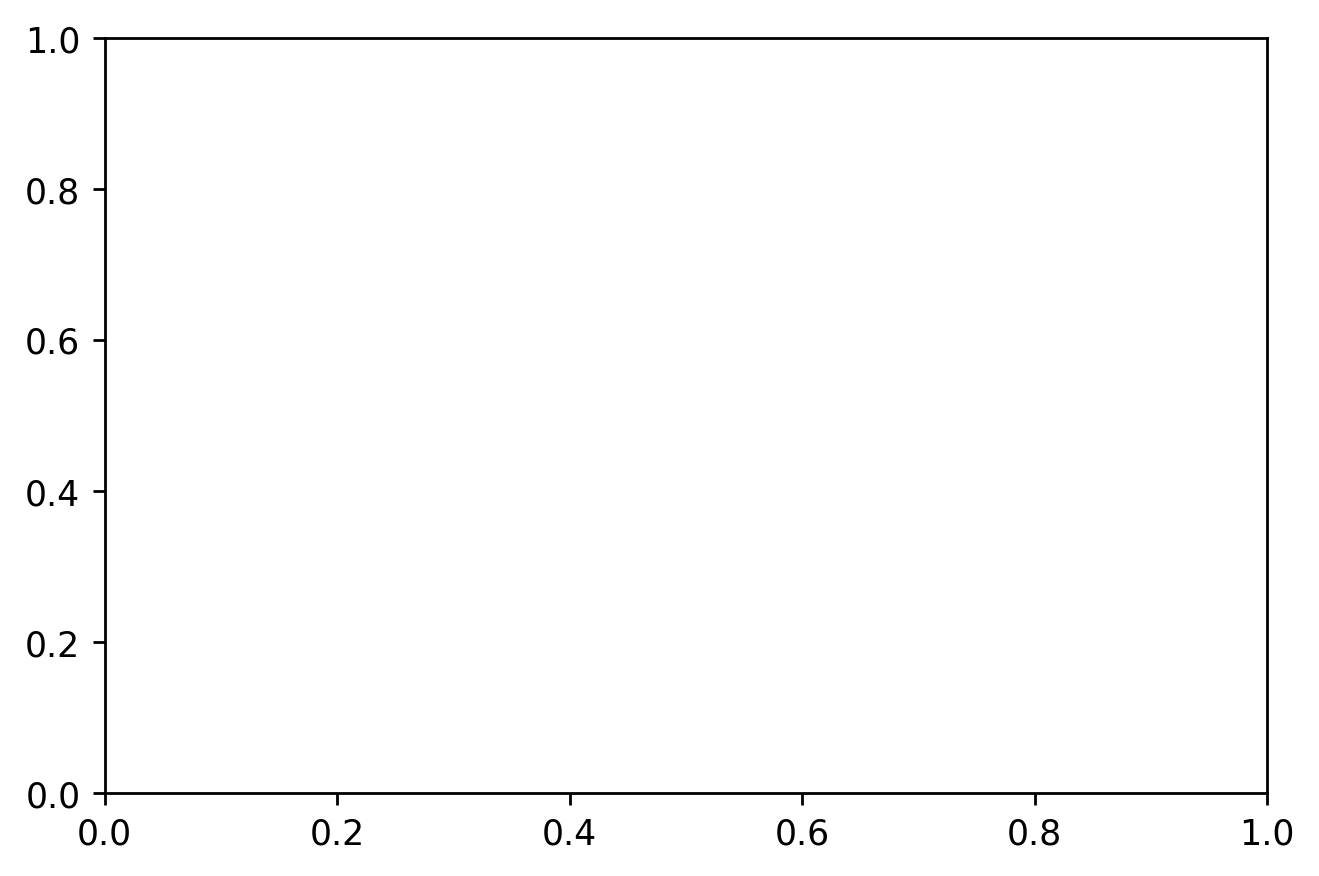

<Figure size 1200x800 with 0 Axes>

In [110]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pyproj import Proj
#Variables from configuration files
import config

ProcessedPath = config.SavePath
GROUPS = config.GROUPS

max_days = {}
for j in GROUPS:
    
    SavePath = ProcessedPath + str(j) + '/GPS_Days/'
    paths = os.listdir(SavePath)
    date,ind= [],[]
    for i in paths:
        data =  pd.read_csv(SavePath + '/'+ i ,index_col=0)
        
        date.append(i)
        ind.append(len(data['Individual'].unique()))
    max_item = max(ind)
    if max_item>=5:
        index_list = [date[index] for index in range(len(ind)) if ind[index] == max_item]
        max_days[j] = [index_list,max_item]
    
def sync_gps_simultaneous(data,k,j):
    print('Duration of data',data.shape[0])
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    df =  data.groupby('Timestamp')
    dfnew = df.filter(lambda x: len(x['Individual'].unique())>=5)
    
    pp = Proj(proj='utm',zone=34,ellps='WGS84',south=True)

    xx, yy = pp(dfnew["lon"].values,dfnew["lat"].values)
    dfnew["X"] = xx
    dfnew["Y"] = yy 

    
    
    dfnew = dfnew.reset_index(drop=True)
    
    times = sorted(dfnew['Timestamp'].unique())
    time_start = times[0]
    time_end = times[-1]

    time_start = time_start + pd.Timedelta(seconds=30)
    time_end = time_end - pd.Timedelta(seconds=30)

    dfnew = dfnew.loc[(dfnew['Timestamp']>=time_start) & (dfnew['Timestamp']<=time_end)] 
    if j == '2021-05-18':  
        print('Seconds removed: ',len(dfnew.loc[((dfnew['X']<581950) & (dfnew['Y']>(7.02035e6)))]))
        dfnew = dfnew.loc[~((dfnew['X']<581950) & (dfnew['Y']>(7.02035e6)))] #for 3 erroneous points on '2021-05-18', remove for others
    
    else:
        pass
    dfnew=dfnew.reset_index(drop=True)
    
    print('Duration of Simultaneous data',dfnew.shape[0])
    return dfnew


k = 'ZU_2021_1' #ZGroups
j = '2021-05-20' #Day
fig,ax= plt.subplots(dpi=250)
data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
data = sync_gps_simultaneous(data,k,j)

cdict = {0:'green', 1: 'blue', 2: 'red'}
data['codes'] = data['Behavior'].astype('category').cat.codes
path = '/media/amlan/Data/Thesis Data/Plots/'+str(j)+'_'+str(k)


time_start= j +' 08:56:46'
time_start =  pd.to_datetime(time_start)

time_end = j +' 09:05:59'
time_end =  pd.to_datetime(time_end)


subset = data.loc[(data['Timestamp']>=time_start) & (data['Timestamp']<=time_end)]
subset = subset.replace([np.inf, -np.inf], np.nan)
subset= subset.reset_index(drop=True)



shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True) 


for key,value in subset.groupby('Timestamp'):
    fig,ax = plt.subplots(dpi=200)
    #ax.set_aspect('equal', adjustable='box')
    
    width = 2
    ax.set_xlim(subset['X'].min()-width, subset['X'].max()+width)
    ax.set_ylim(subset['Y'].min()-width, subset['Y'].max()+width)
    
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.set_title('{} : {}'.format(k,key))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    
    colors = value['codes'].apply(lambda x: cdict[x])
    ax.grid()
    ax.tick_params(axis='x', rotation=45)
    ax.scatter(value['X'],value['Y'],c=colors,label=value['Individual'])
    
    red_patch = mpatches.Patch(color='red', label='Vigilance')
    green_patch = mpatches.Patch(color='green', label='Foraging')
    blue_patch = mpatches.Patch(color='blue', label='Running')

    ax.legend(handles=[red_patch,green_patch, blue_patch])
    
    plt.tight_layout()
    plt.savefig(path +'/' + str(key),dpi=250)
    plt.close(fig)
    


import imageio.v2 as imageio
png_dir = path
with imageio.get_writer('/media/amlan/Data/Thesis Data/Plots/'+str(k + '_' + j)+'.gif', mode='I',fps=15) as writer:
    for filename in sorted(os.listdir(png_dir)):
        image = imageio.imread(path+'/'+filename)
        writer.append_data(image)

In [111]:
subset['X'].min()-width

581726.0703189886

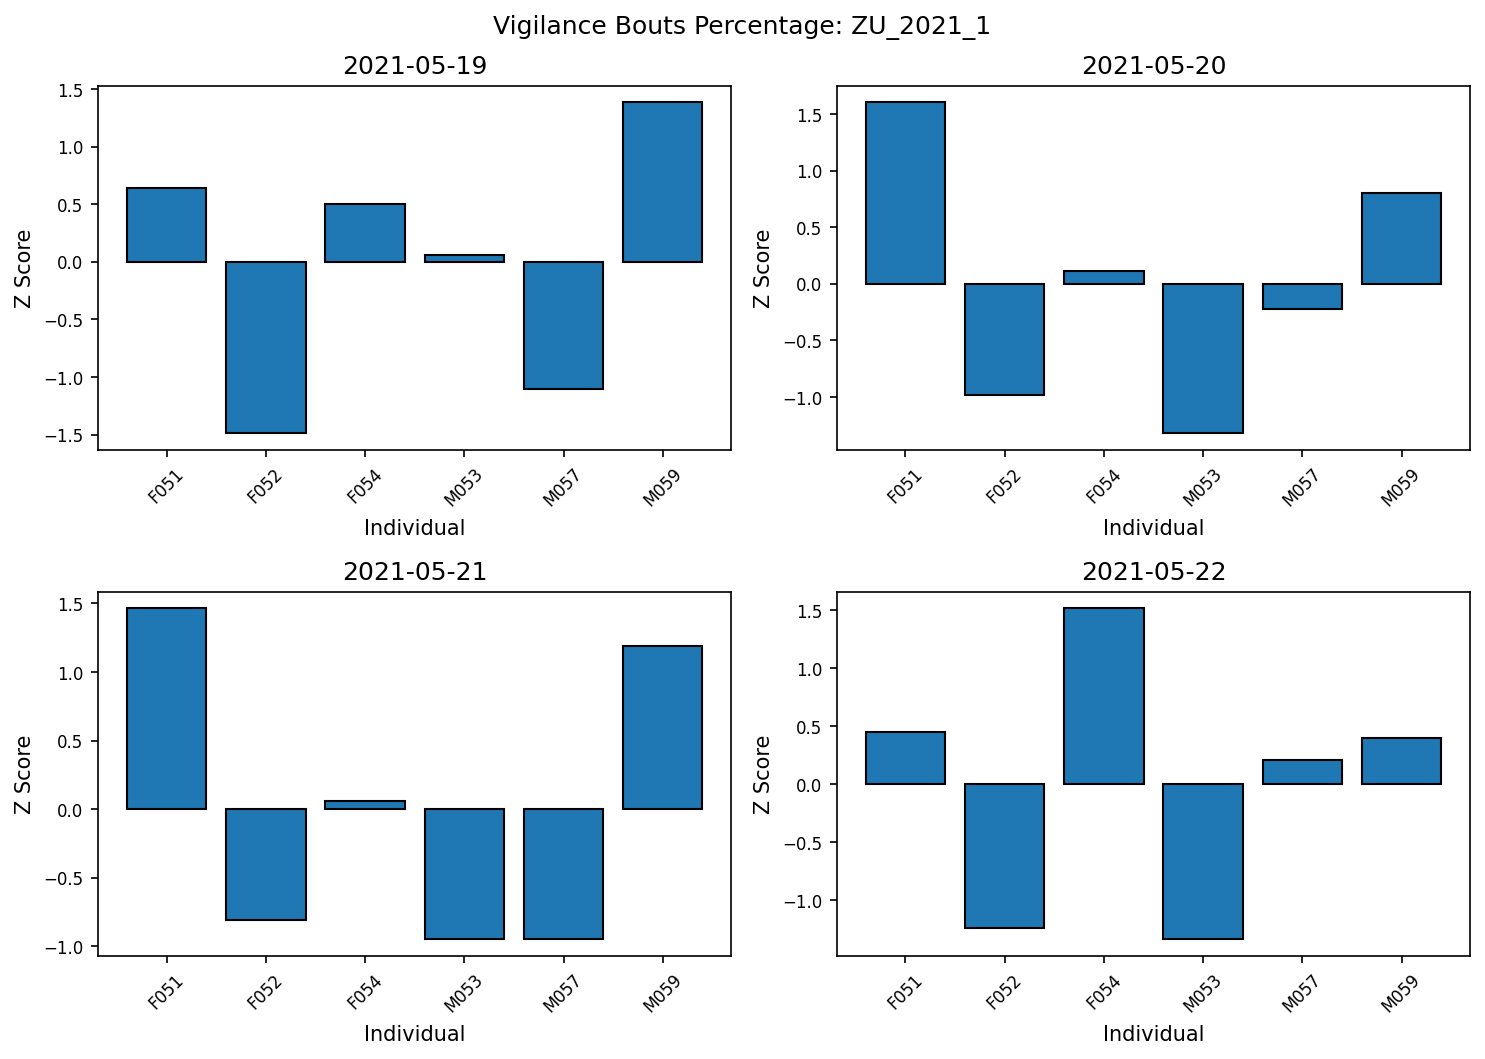

In [63]:
k = 'ZU_2021_1'

fig,ax = plt.subplots(nrows=3,ncols=2, figsize=(10, 10),dpi=150)
ax = ax.flatten()

i = 0
for j in max_days[k][0]:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    df =  data.groupby('Timestamp')
    dfnew = df.filter(lambda x: len(x['Individual'].unique())>=max_days[k][1])
    dfnew = dfnew.reset_index(drop=True)
    vigilance,ind = [],[]
    for key,value in dfnew.groupby('Individual'):
        vigilance.append((value['Behavior'] == 'Vigilance').sum()/len(value['Behavior']))
        ind.append(key[3:])
    vigilance = [(i - np.mean(vigilance))/np.std(vigilance) for i in vigilance]
    #(i - np.mean(vigilance))/np.std(vigilance)
    ax[i].set_title(j)
    ax[i].set_xlabel('Individual')
    ax[i].set_ylabel('Z Score')
    ax[i].bar(ind,vigilance, edgecolor="k")
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].tick_params(axis='x', rotation=45)
    i = i + 1

for a in ax[len(max_days[k][0]):]:
    a.remove()
fig.suptitle('Vigilance Bouts Percentage: {}'.format(k))
plt.tight_layout()
plt.show()

['0:2021-05-19', '1:2021-05-20', '2:2021-05-21', '3:2021-05-22']
['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']


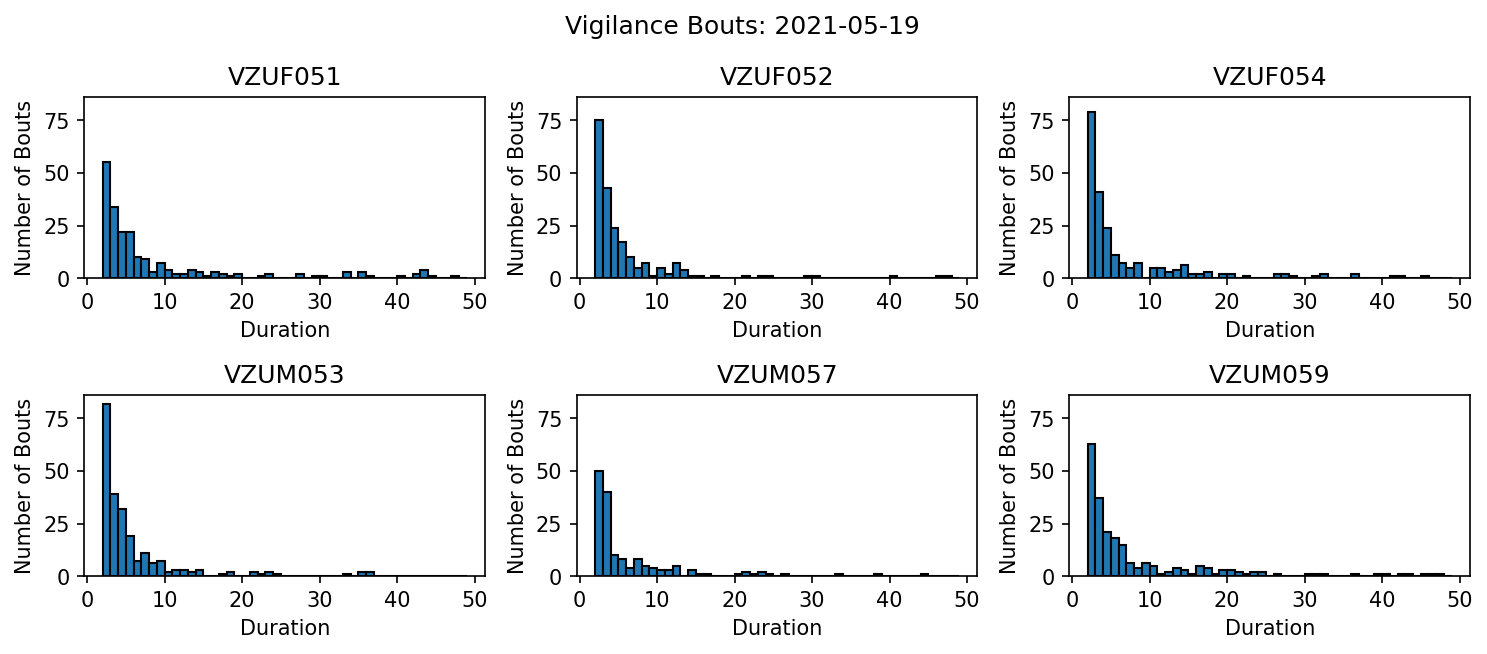

['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']


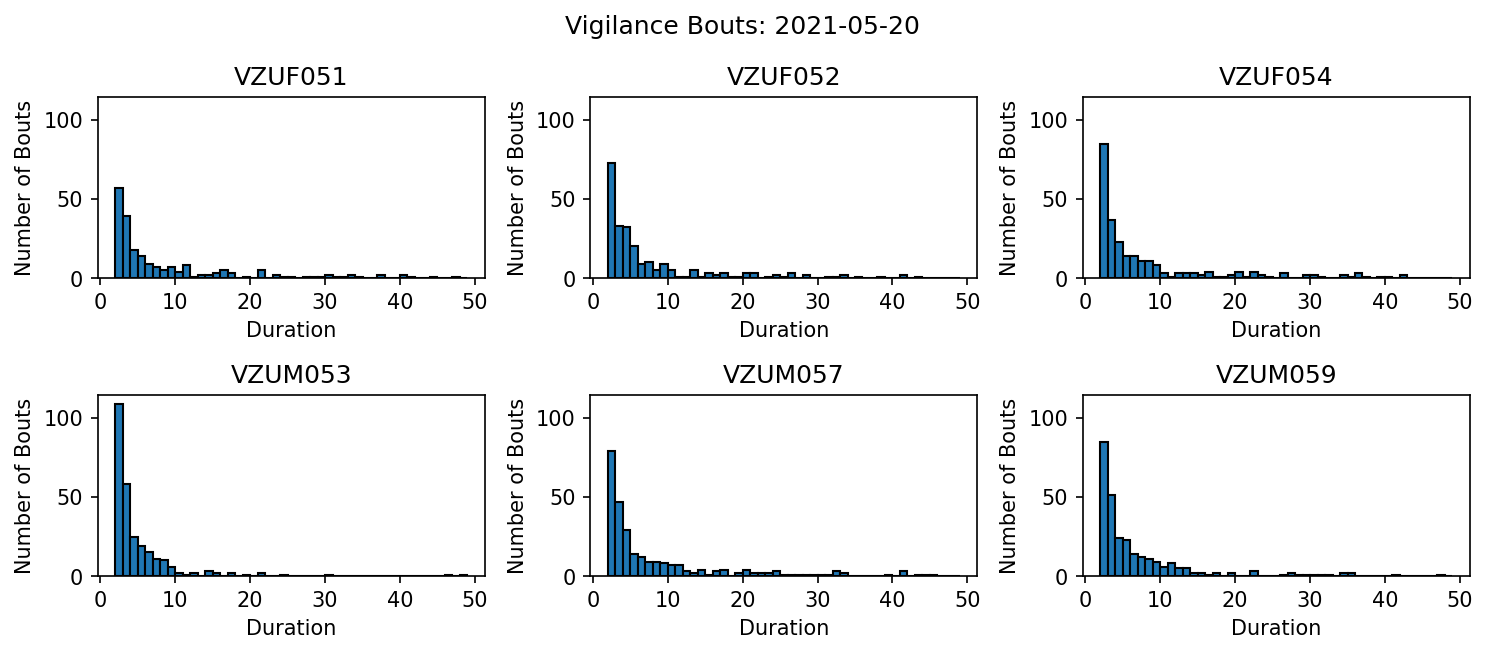

['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']


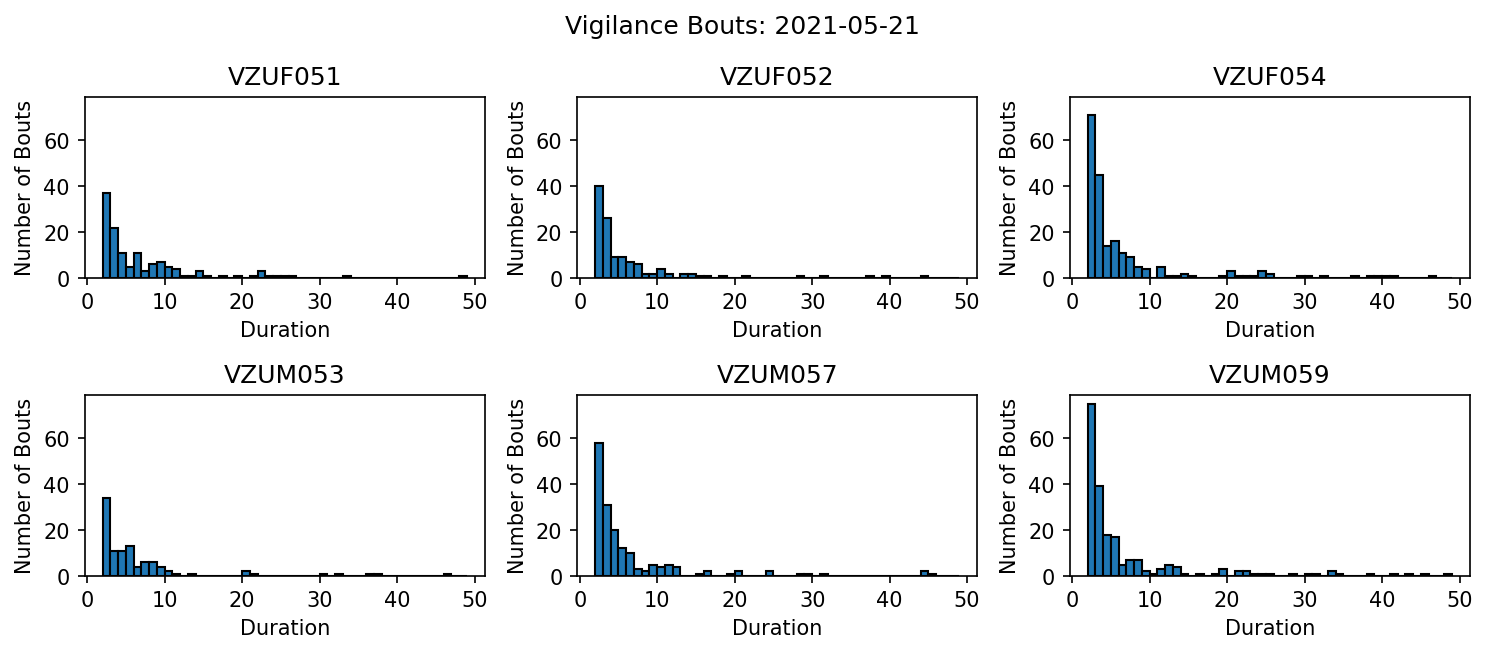

['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']


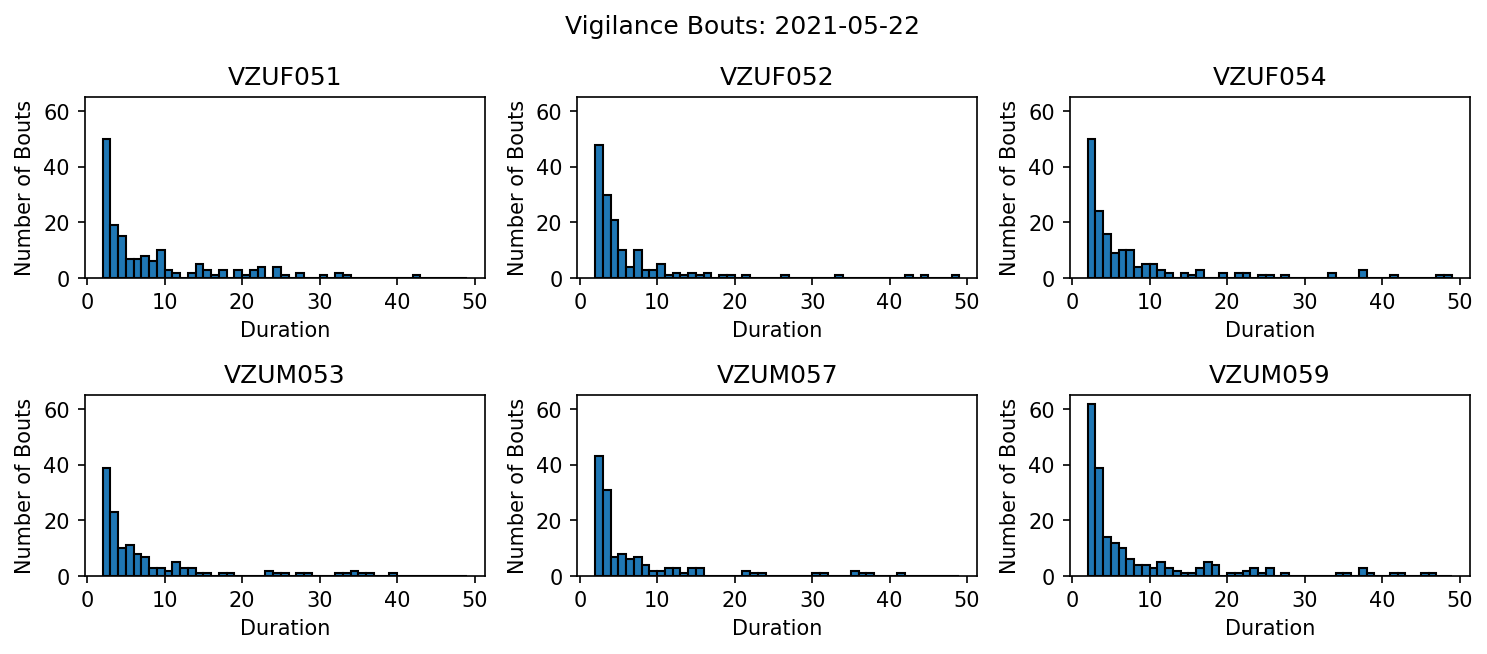

In [57]:
k = 'ZU_2021_1'

print([str(i) + ':' + str(max_days[k][0][i]) for i in range(len(max_days[k][0]))])



for j in max_days[k][0]:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    print(sorted(data['Individual'].unique()))
    df =  data.groupby('Timestamp')
    
    dfnew = df.filter(lambda x: len(x['Individual'].unique())>=2)
    dfnew = dfnew.reset_index(drop=True)
    i=0
    fig,ax = plt.subplots(nrows=3,ncols=3, figsize=(10, 6),dpi=150,sharex=True,sharey=True)
    ax = ax.flatten()
    for key,value in dfnew.groupby('Individual'):
        df_ = value.loc[value['Behavior']!='Vigilance']
        diffs = np.diff(df_.index)
        fig.suptitle('Vigilance Bouts: ' + str(j))
        ax[i].set_title(key)
        ax[i].set_xlabel('Duration')
        ax[i].set_ylabel('Number of Bouts')
        ax[i].xaxis.set_tick_params(labelbottom=True)
        ax[i].yaxis.set_tick_params(labelbottom=True)
        ax[i].hist(diffs[diffs>1],bins=np.arange(2,50), edgecolor="k")
        i = i + 1
    for a in ax[len(max_days[k][0])+2:]:
        a.remove()
    plt.tight_layout()
    plt.show()

['0:2021-05-19', '1:2021-05-20', '2:2021-05-21', '3:2021-05-22']
['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']
['VZUF051', 'VZUF052', 'VZUF054', 'VZUM053', 'VZUM057', 'VZUM059']


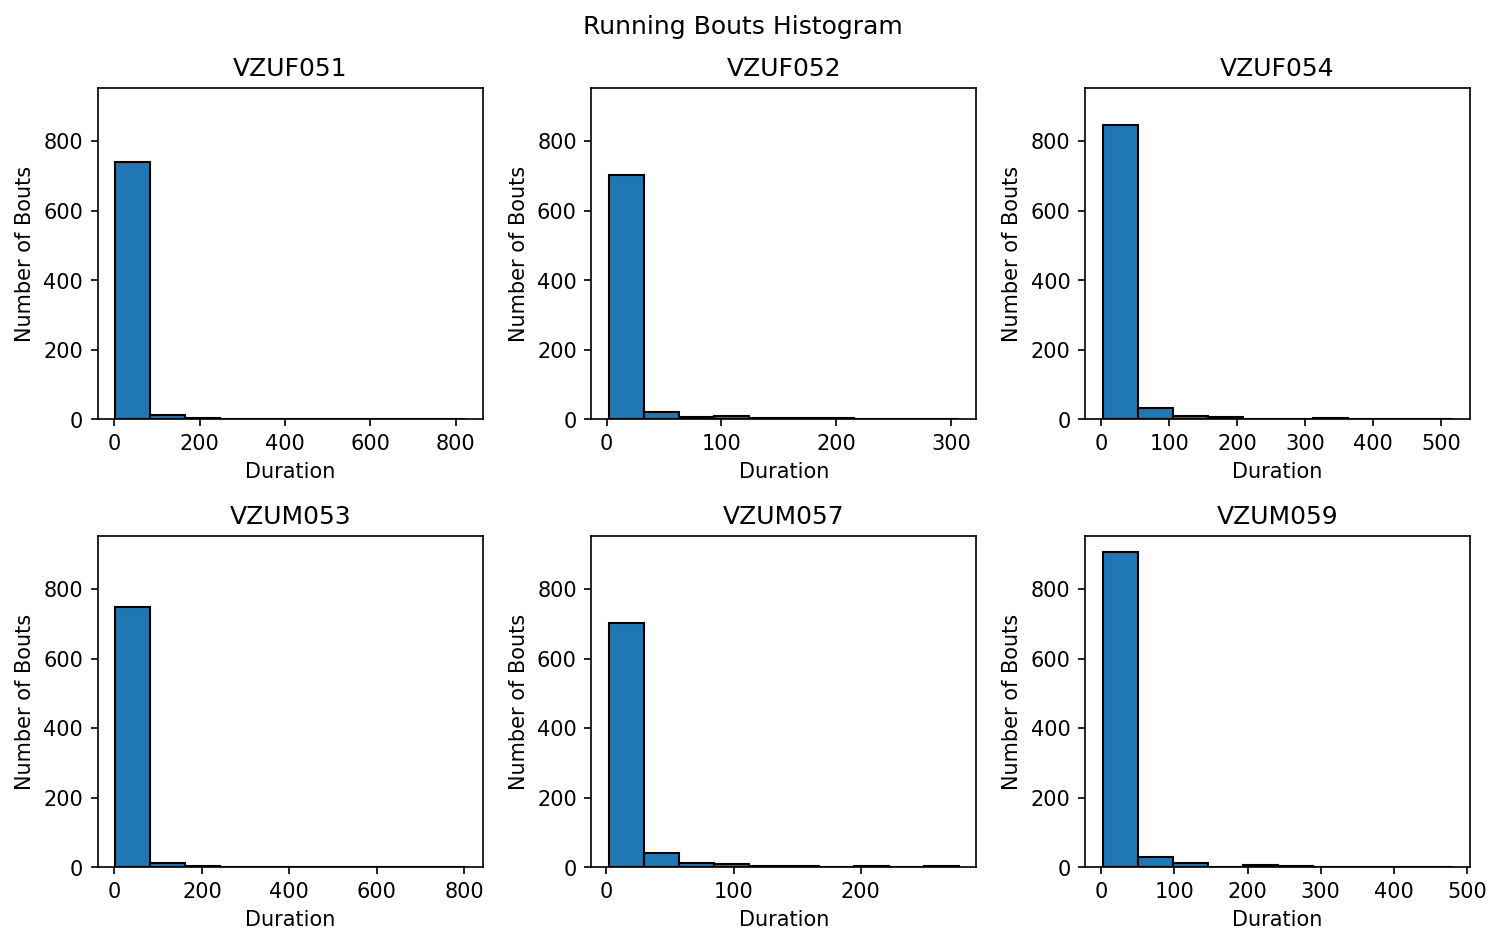

In [36]:
k = 'ZU_2021_1'

print([str(i) + ':' + str(max_days[k][0][i]) for i in range(len(max_days[k][0]))])



bouts = {}
for j in max_days[k][0]:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    meerkats = sorted(data['Individual'].unique())
    print(meerkats)
    df =  data.groupby('Timestamp')
    
    dfnew = df.filter(lambda x: len(x['Individual'].unique())>=2)
    dfnew = dfnew.reset_index(drop=True)
    
    
    for key,value in dfnew.groupby('Individual'):
        df_ = value.loc[value['Behavior']!='Vigilance']
        diffs = np.diff(df_.index)
        for q in diffs:
            bouts.setdefault(key,[]).append(q)
fig,ax = plt.subplots(nrows=3,ncols=3, figsize=(10, 9),dpi=150,sharey=True)#,sharex=True)
ax = ax.flatten()
i=0 
bouts_dict = {}
for m in meerkats:
        fig.suptitle('Running Bouts Histogram')
        ax[i].set_title(m)
        ax[i].set_xlabel('Duration')
        ax[i].set_ylabel('Number of Bouts')
        ax[i].xaxis.set_tick_params(labelbottom=True)
        ax[i].yaxis.set_tick_params(labelbottom=True)
        b = np.array(bouts[m])
        bouts_dict[m] = b
        ax[i].hist(b[b>1],edgecolor="k")
        i = i + 1
for a in ax[len(max_days[k][0])+2:]:
    a.remove()
plt.tight_layout()
plt.show()

In [38]:
bouts_dict

{'VZUF051': array([1, 1, 1, ..., 1, 1, 1]),
 'VZUF052': array([1, 1, 1, ..., 1, 1, 1]),
 'VZUF054': array([1, 1, 1, ..., 1, 1, 1]),
 'VZUM053': array([1, 1, 1, ..., 1, 1, 1]),
 'VZUM057': array([1, 1, 1, ..., 1, 1, 1]),
 'VZUM059': array([1, 1, 1, ..., 1, 1, 1])}

Percentage of Missing Data:  3.8464519629500447


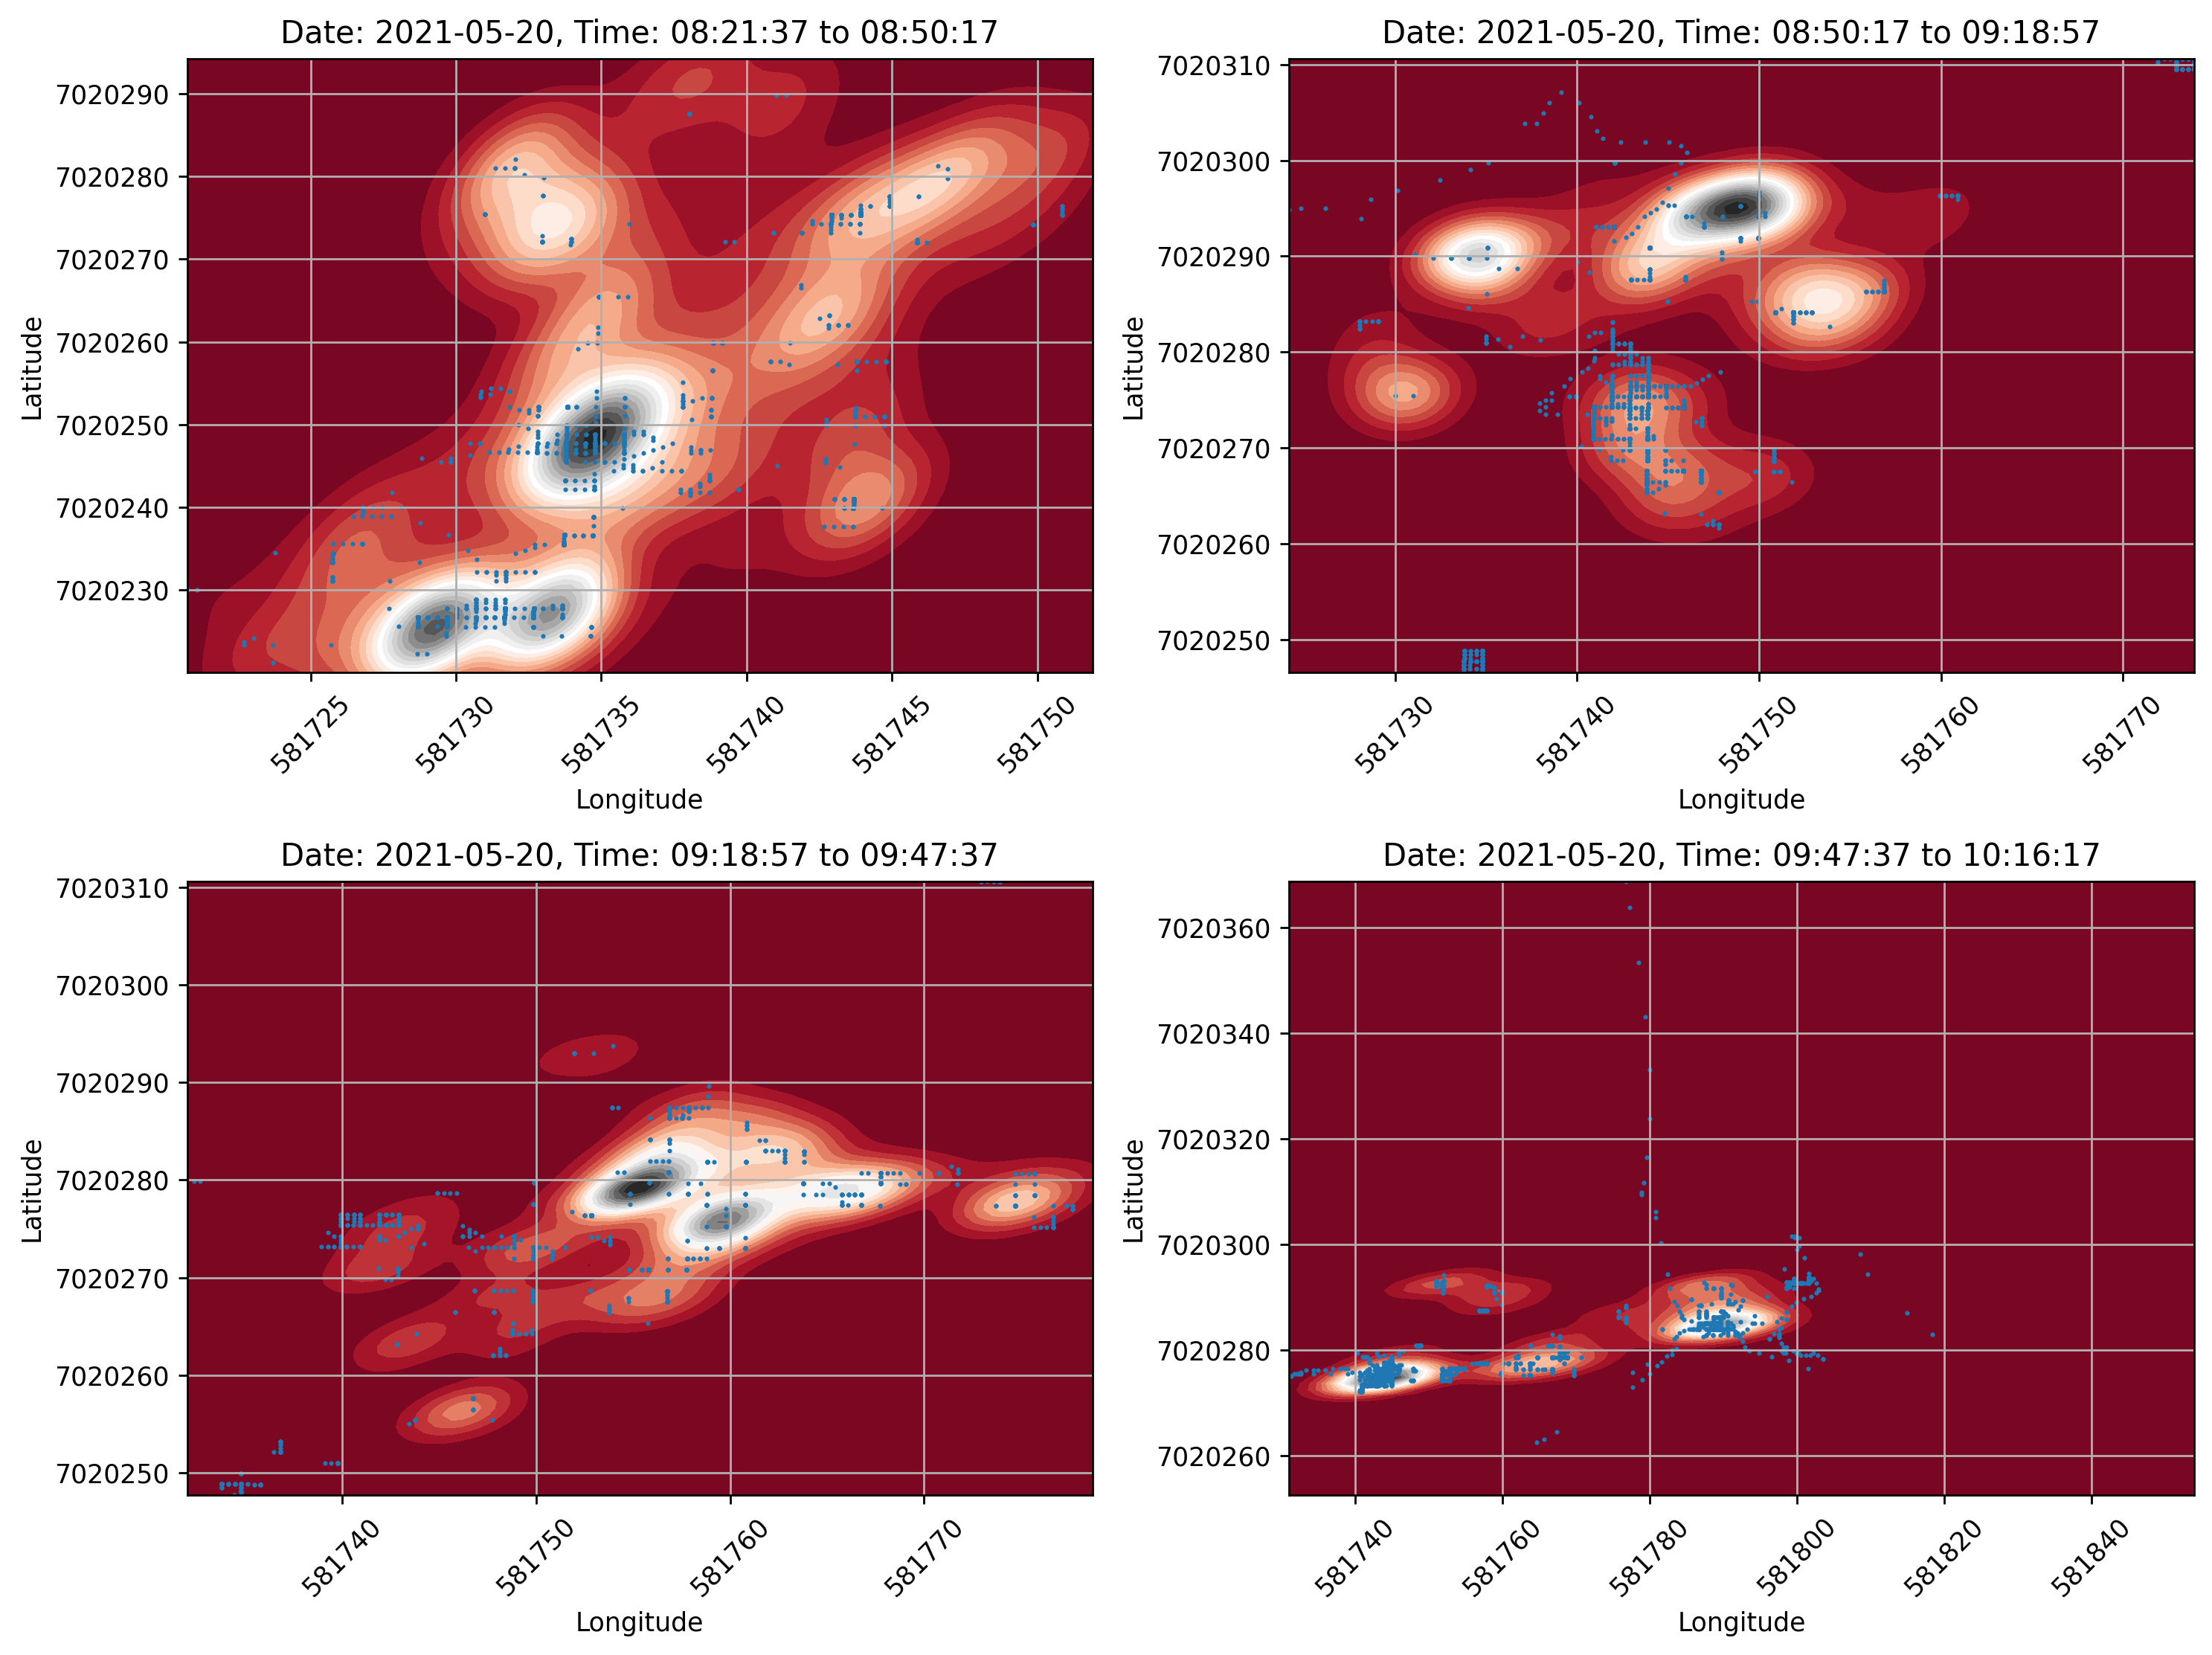

In [114]:
from scipy.stats import gaussian_kde
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=False)

k = 'ZU_2021_1'
for j in max_days[k][0][2:3]:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    start_time =  data.iloc[0,0]
    end_time =  data.iloc[-1,0]
    data = data.loc[(data['Timestamp'] >= start_time + pd.Timedelta(minutes=15)) & (data['Timestamp'] <= end_time - pd.Timedelta(minutes=15))]
    print('Percentage of Missing Data: ',data.loc[data['lat'].isna()].shape[0]*500 / data.shape[0])
    data = data.dropna(axis=0)
    data.reset_index(drop=True,inplace=True)
    
    pp = Proj(proj='utm',zone=34,ellps='WGS84',south=True)

    xx, yy = pp(data["lon"].values,data["lat"].values)
    data["X"] = xx
    data["Y"] = yy 
    
    pieces = [(int((data.iloc[-1,0] - data.iloc[0,0]).total_seconds())//5 )*i for i in range(5)]
    time_start = data.iloc[0,0]
    
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,9),dpi=250)
    ax = ax.flatten()
    i=0
    for m in range(len(pieces)-1):
        
        chunk = data.loc[(data['Timestamp'] > time_start + pd.Timedelta(seconds=pieces[m])) & (data['Timestamp']<=time_start + pd.Timedelta(seconds=pieces[m+1]))]
        chunk = chunk.reset_index(drop=True)
                 
        
        X, Y = np.meshgrid(np.linspace(np.min(chunk['X']), np.max(chunk['X']), 100), np.linspace(np.min(chunk['Y']), np.max(chunk['Y']), 100))
        
        x = chunk.loc[chunk['Behavior']=='Foraging','X']
        y = chunk.loc[chunk['Behavior']=='Foraging','Y']
        kde = gaussian_kde(np.vstack([x, y]))

        Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
        ax[i].contourf(X, Y, Z,20, cmap='RdGy')
        ax[i].set_title('Date: {}, Time: {} to {}'.format(time_start.date(),(time_start + pd.Timedelta(seconds=pieces[m])).time(),(time_start + pd.Timedelta(seconds=pieces[m+1])).time()))
        ax[i].yaxis.set_major_formatter(y_formatter)
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        ax[i].grid()
        ax[i].scatter(chunk.loc[chunk['Behavior']=='Vigilance','X'],chunk.loc[chunk['Behavior']=='Vigilance','Y'],s=0.6)
        ax[i].xaxis.set_major_formatter(y_formatter)
        ax[i].tick_params(axis='x', rotation=45)
        
        i = i + 1
    plt.tight_layout()
    plt.show()
    

Percentage of Missing Data:  0.861701715657798


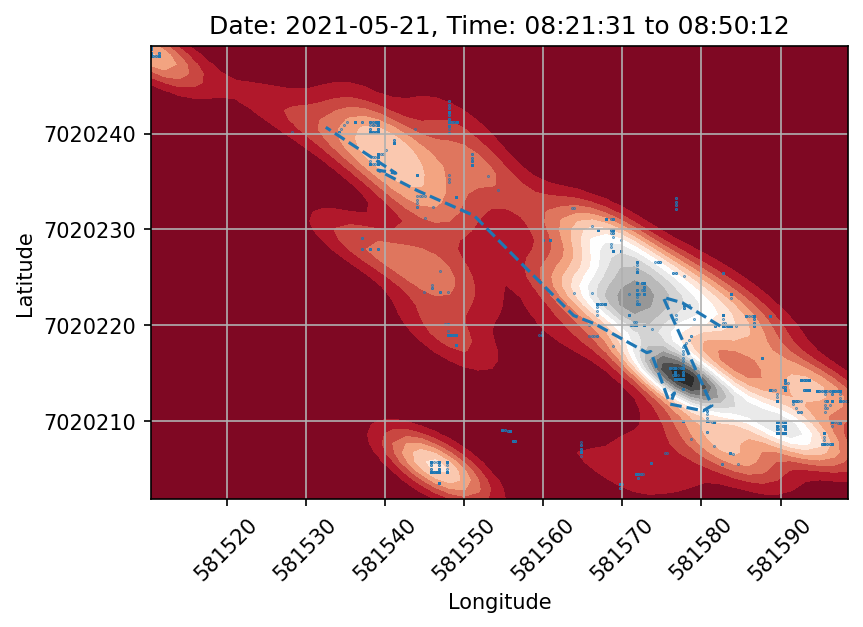

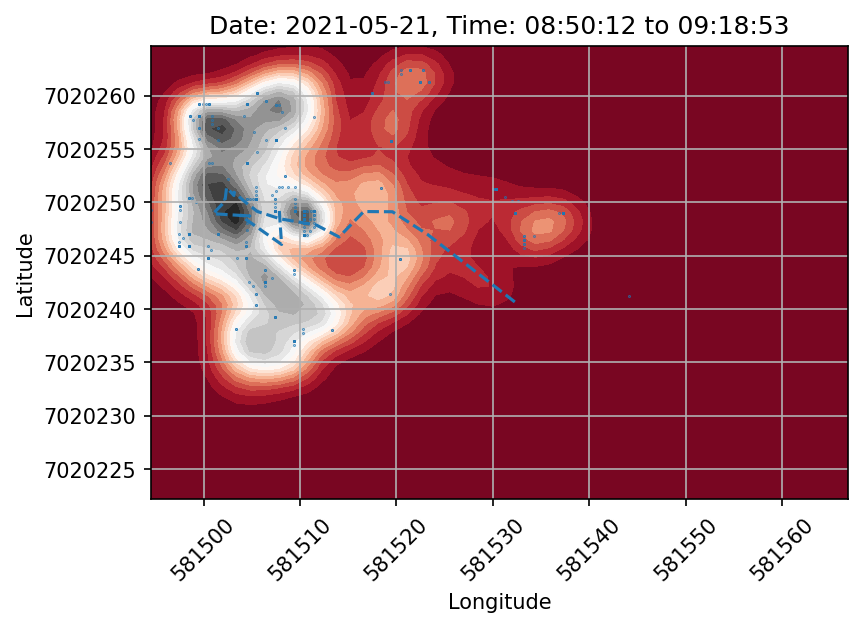

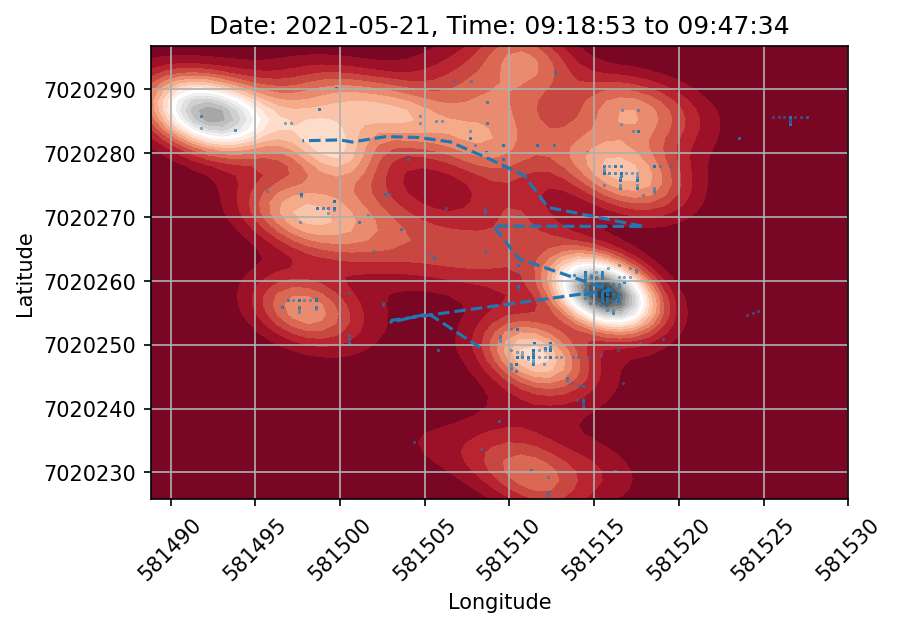

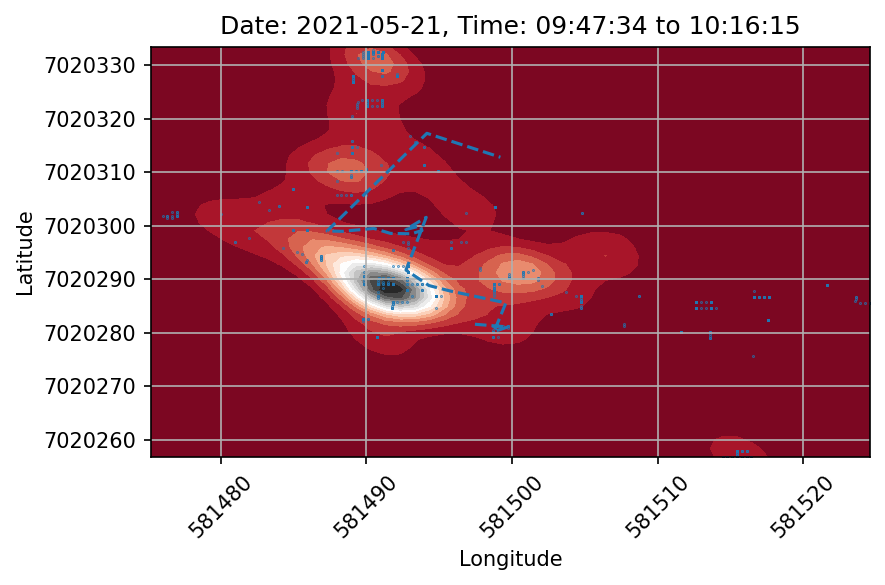

In [62]:
from scipy.stats import gaussian_kde
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=False)

def plot_veg(ax):
    

k = 'ZU_2021_1'
for j in max_days[k][0][2:3]:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    start_time =  data.iloc[0,0]
    end_time =  data.iloc[-1,0]
    data = data.loc[(data['Timestamp'] >= start_time + pd.Timedelta(minutes=15)) & (data['Timestamp'] <= end_time - pd.Timedelta(minutes=15))]
    print('Percentage of Missing Data: ',data.loc[data['lat'].isna()].shape[0]*500 / data.shape[0])
    data = data.dropna(axis=0)
    data.reset_index(drop=True,inplace=True)
    
    pp = Proj(proj='utm',zone=34,ellps='WGS84',south=True)

    xx, yy = pp(data["lon"].values,data["lat"].values)
    data["X"] = xx
    data["Y"] = yy 
    
    pieces = [(int((data.iloc[-1,0] - data.iloc[0,0]).total_seconds())//5 )*i for i in range(5)]
    time_start = data.iloc[0,0]
    
    
    for m in range(len(pieces)-1):
        
        chunk = data.loc[(data['Timestamp'] > time_start + pd.Timedelta(seconds=pieces[m])) & (data['Timestamp']<=time_start + pd.Timedelta(seconds=pieces[m+1]))]
        chunk = chunk.reset_index(drop=True)
                 
        fig,ax = plt.subplots(dpi=150)
        X, Y = np.meshgrid(np.linspace(np.min(chunk['X']), np.max(chunk['X']), 50), np.linspace(np.min(chunk['Y']), np.max(chunk['Y']), 50))
        
        x = chunk['X']
        y = chunk['Y']
        kde = gaussian_kde(np.vstack([x, y]))

        Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
        ax.contourf(X, Y, Z,20, cmap='RdGy')
        ax.set_title('Date: {}, Time: {} to {}'.format(time_start.date(),(time_start + pd.Timedelta(seconds=pieces[m])).time(),(time_start + pd.Timedelta(seconds=pieces[m+1])).time()))
        ax.yaxis.set_major_formatter(y_formatter)
        ax.grid()
        ax.scatter(chunk.loc[chunk['Behavior']=='Vigilance','X'],chunk.loc[chunk['Behavior']=='Vigilance','Y'],s=0.1)
        ax.xaxis.set_major_formatter(y_formatter)
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        centroid = pd.DataFrame()
        for i in sorted(chunk['Timestamp'].unique())[0::100]:
            subset = chunk.loc[chunk['Timestamp']==i,['X','Y']]
            
            subset = np.sum(subset,axis=0) / subset.shape[0]
            
            centroid = pd.concat([centroid,subset.T],axis=0)
        centroid = centroid.reset_index(drop=True)
        ax.plot(centroid.iloc[0::2],centroid.iloc[1::2],'--')
        
        
    plt.tight_layout()
    plt.show()
    

In [118]:
metrics = extract_move(dfnew)

<AxesSubplot:>

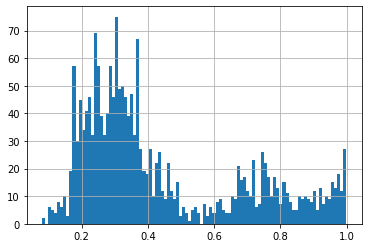

In [128]:
metrics.loc[metrics['Spread']<1,'Spread'].hist(bins=100)

<AxesSubplot:>

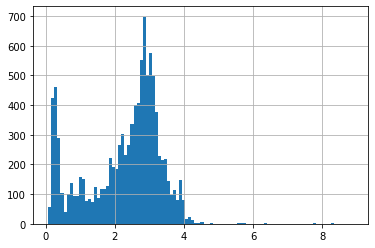

In [127]:
metrics['Spread'].hist(bins=100)

In [139]:
(dfnew.loc[dfnew['Timestamp']=='2021-05-19 08:06:46','Behavior'])

0        Foraging
10390    Foraging
20780    Foraging
31170    Foraging
41560    Foraging
51950    Foraging
Name: Behavior, dtype: object

(array([ 885., 1060.,  717.,  405.,  170.,   54.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

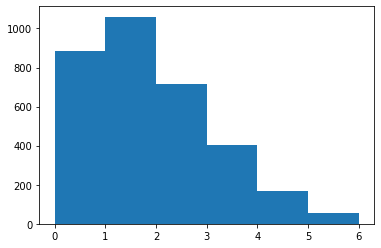

In [150]:
vigilance=[]
for i in metrics.loc[metrics['Spread']<1.5,'Timestamp']:
    number = (dfnew.loc[dfnew['Timestamp']==i,'Behavior'] == 'Vigilance').sum()
    vigilance.append(number)
plt.hist(vigilance,bins=6)

(array([3497., 2499., 1249.,  397.,   92.,  143.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

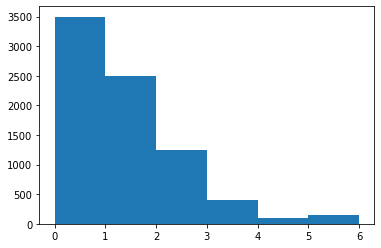

In [151]:
vigilance=[]
for i in metrics.loc[metrics['Spread']>1.5,'Timestamp']:
    number = (dfnew.loc[dfnew['Timestamp']==i,'Behavior'] == 'Vigilance').sum()
    vigilance.append(number)
plt.hist(vigilance,bins=6)

In [174]:
n=np.random.randint(metrics.shape[0])
df = metrics.loc[n:n+600,:]

In [180]:
maj_vig = []
for i in df['Timestamp']:
    number = (dfnew.loc[dfnew['Timestamp']==i,'Behavior'] == 'Vigilance').sum()
    if number>=4:
        maj_vig.append(i)
    

In [181]:
len(maj_vig)

10

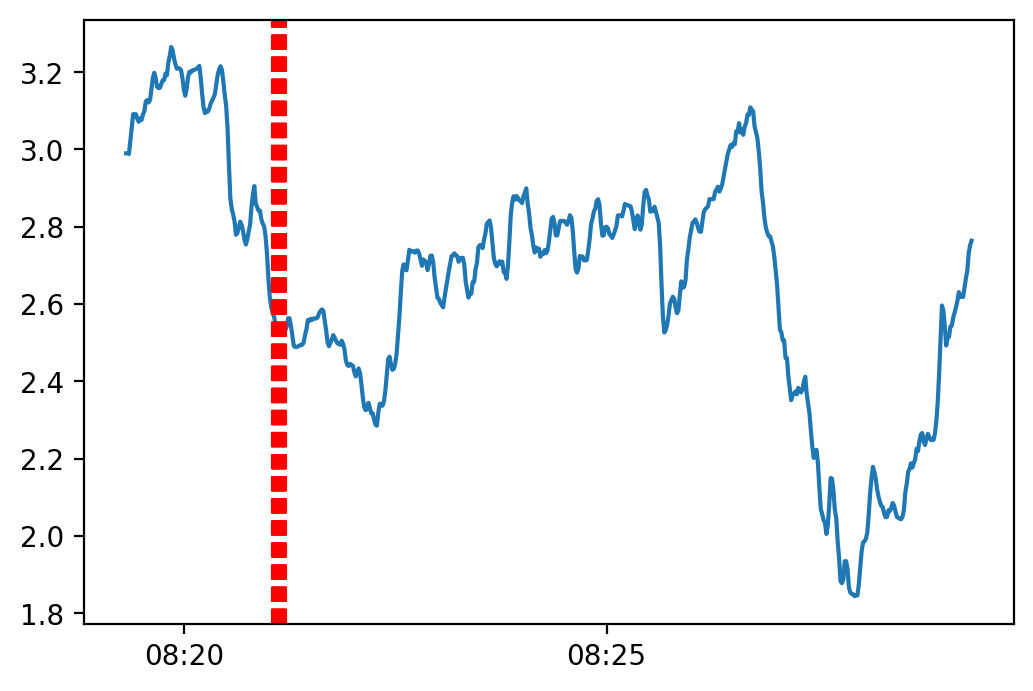

In [183]:
import matplotlib.dates as mdates
fig,ax = plt.subplots(dpi=200)
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(df['Timestamp'],df['Spread'])
for j in maj_vig:
    plt.axvline(x=j, color='r',label = 'Vigilance',ls='--')
        